In [1]:
# Install required packages
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
#dotenv module
from dotenv import load_dotenv
_ = load_dotenv()

In [3]:
from typing import Annotated
from typing_extensions import TypedDict


In [4]:
from langchain.chat_models import init_chat_model


# Gemini
llm = init_chat_model("google_genai:gemini-2.5-pro")

# OpenAI
# llm = init_chat_model("openai:gpt-4.1")

In [5]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results = 2)
tools = [tool]

In [6]:

from langchain_core.messages import BaseMessage
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


In [7]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)


llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools= [tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

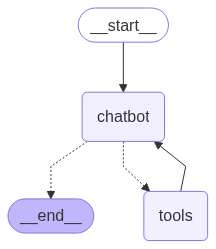

In [8]:
# We can easily display the graph we have created
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
result = graph.invoke({"messages": ["What is the weather in San Francisco?"]})
print(result['messages'][-1].content)
print(result)

Which SF are you referring to? San Francisco, CA or Sioux Falls, SD?
{'messages': [HumanMessage(content='What is the weather in sf?', additional_kwargs={}, response_metadata={}, id='546477ee-c993-44eb-b8c5-ebfe4b567ca0'), AIMessage(content='Which SF are you referring to? San Francisco, CA or Sioux Falls, SD?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-pro', 'safety_ratings': []}, id='run--29c4efe1-b65b-4aad-be8b-09e4714fc779-0', usage_metadata={'input_tokens': 598, 'output_tokens': 17, 'total_tokens': 788, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 173}})]}
